We start by importing the calls for basic functions we use with the modeling. Numpy is for controlling data and matplotlib is for graphics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Next we will import the model and the odesolver from pysb

In [3]:
from pysb.examples.robertson import model
from pysb.integrate import odesolve
import pysb

We will integrate the model for 40 seconds.

In [4]:
t = np.linspace(0, 40,100)
obs_names = ['A_total', 'C_total']

Here we setup the ode solver. We pass it the model, time, and any extra arguments.

In [5]:
solver = pysb.integrate.Solver(model, t, integrator='vode',rtol=1e-8, atol=1e-8)

In [6]:
solver.run()

In [7]:
def normalize(trajectories):
    """Rescale a matrix of model trajectories to 0-1"""
    ymin = trajectories.min(0)
    ymax = trajectories.max(0)
    return (trajectories - ymin) / (ymax - ymin)


def extract_records(recarray, names):
    """Convert a record-type array and list of names into a float array"""
    return np.vstack([recarray[name] for name in names]).T

In [8]:
ysim_array = extract_records(solver.yobs, obs_names)
norm_data = normalize(ysim_array)

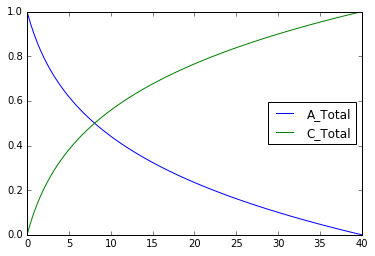

In [9]:
plt.plot(t,norm_data)
plt.legend(['A_Total','C_Total'], loc = 0)

We are going to make some noisy data for optimization.

In [10]:
noisy_data_A = ysim_array[:,0] + np.random.uniform(-0.02,0.02,np.shape(ysim_array[:,0]))
norm_noisy_data_A = normalize(noisy_data_A)
noisy_data_C = ysim_array[:,1] + np.random.uniform(-.02,.01,np.shape(ysim_array[:,1]))
norm_noisy_data_C = normalize(noisy_data_C)
ydata_norm = np.column_stack((norm_noisy_data_A,norm_noisy_data_C))

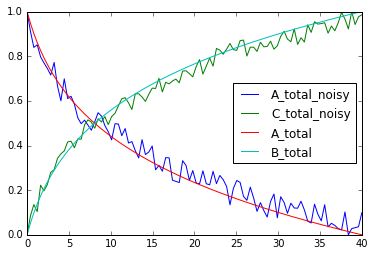

In [11]:
plt.plot(t,norm_noisy_data_A)
plt.plot(t,norm_noisy_data_C)
plt.plot(t,norm_data)
plt.legend(['A_total_noisy','C_total_noisy','A_total', 'B_total', 'C_total'], loc=0)

In [24]:
from simplepso.pso import PSO

Now we need to define a few things to simply the process.
We want to optimize only the rate parameters, assuming that initial conditions are OK.
We also define bounds, here up and down 1 order of magnitude (in log10 space).

In [25]:
rate_params = model.parameters_rules()
param_values = np.array([p.value for p in model.parameters])
rate_mask = np.array([p in rate_params for p in model.parameters])

nominal_values = np.array([p.value for p in model.parameters])
xnominal = np.log10(nominal_values[rate_mask]) 
bounds_radius = 2
lb = xnominal - bounds_radius
ub = xnominal + bounds_radius

This is just a small function to the same plot over and over again. Power of functions!
Now we can plot the results directly.

In [26]:
def display(x=None):
    if x == None:
        solver.run(param_values)
    else:
        Y=np.copy(x)
        param_values[rate_mask] = 10 ** Y
        solver.run(param_values)
    ysim_array = extract_records(solver.yobs, obs_names)
    ysim_norm = normalize(ysim_array)
    count=1
    plt.figure(figsize=(8,6),dpi=200)
    plt.plot(t,ysim_norm[:,0],label='A')
    plt.plot(t,ysim_norm[:,1],label='C')
    plt.plot(t,norm_noisy_data_A,label='Noisy A')
    plt.plot(t,norm_noisy_data_C,label='Noisy C')
    plt.legend(loc=0)
    plt.ylabel('concentration')
    plt.xlabel('time (s)')
    plt.show()

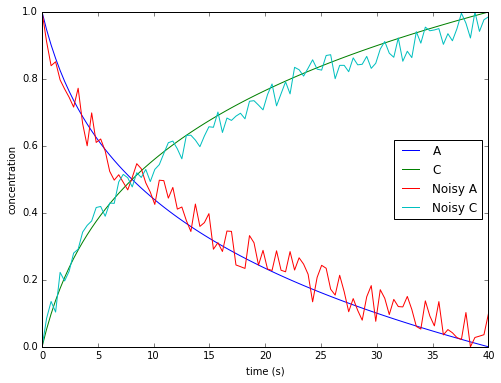

In [27]:
display()

To demonstrate we need to perturb our models parameters.

In [28]:
print xnominal**10
start_position = xnominal +np.random.uniform(-1.0,1.0,size = np.shape(xnominal))
print start_position**10

[  2.85026569e+01   5.46190618e+08   1.04857600e+06]
[  5.81136233e+03   1.36116065e+09   9.05098882e+06]


Now we define an objective function to minimize. Since we don't have experimental data, we will use the synthetic data created above. 

In [29]:
def obj_function(params):
    if np.any((params < lb) | (params> ub)):
        return 1000,
    params_tmp = np.copy(params)
    param_values[rate_mask] = 10 ** params_tmp
    solver.run(param_values)
    ysim_array = extract_records(solver.yobs, obs_names)
    ysim_norm = normalize(ysim_array)
    err = np.sum((ydata_norm - ysim_norm) ** 2 )
    if np.isnan(err):
        return 1000,
    return err,

In [30]:
optimizer = PSO(cost_function=obj_function,start=start_position,verbose=True)

In [31]:
optimizer.set_bounds(parameter_range=1)

In [20]:
optimizer.run(100,100)

Now to view our initial parameters compared to the optimized parameters!

In [21]:
display(start_position)
display(optimizer.best)

In [28]:
print(optimizer.best)
print(xnominal)